In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

### Definition of the model

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

### Integration of the differential equations

In [3]:
def time_evo(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### Show the result

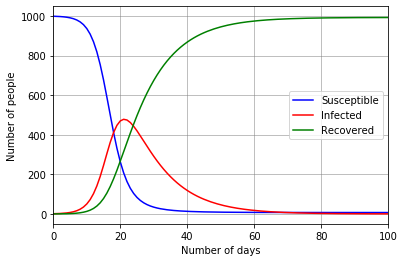

In [4]:
fin_result=time_evo(1000,0.5,0.1)

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]

plt.plot(t, s_vec, 'b', label='Susceptible')
plt.plot(t, i_vec, 'r', label='Infected')
plt.plot(t, r_vec, 'g', label='Recovered')
#plt.plot(t, m_vec, 'k', label='Deaths')
#plt.plot(t, i_vec+r_vec, color='orange',linestyle='--', label='Infected + Recovered')
plt.legend(loc=5)
#plt.yscale('log')
#plt.ylim(0.5,3000)
plt.xlim(0,100)
plt.xlabel('Number of days')
plt.ylabel('Number of people')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('plotsir05.png',dpi=300)
plt.show()

#print(s_vec+i_vec+r_vec+m_vec)

### Load italian data

In [21]:
scelta='regionale'

if scelta=='nazionale':
    data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
    xdata=pd.to_numeric(range(data.shape[0]))
    ydata=data['totale_casi']
    ydata_death=data['deceduti']
    ydata_rec=data['dimessi_guariti']
    ydata_inf=ydata-ydata_rec-ydata_death

elif scelta=='regionale':
    datatot = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
    mask = datatot['denominazione_regione']=='Molise'
    data =datatot.loc[mask,:]
    xdata=pd.to_numeric(range(data.shape[0]))
    ydata=data['totale_casi']
    ydata_death=data['deceduti']
    ydata_rec=data['dimessi_guariti']
    ydata_inf=np.array(ydata-ydata_death-ydata_rec)
    
data.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
11,2020-02-24T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
32,2020-02-25T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
53,2020-02-26T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
74,2020-02-27T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
95,2020-02-28T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [22]:
data.iloc[-1]

data                          2020-05-11T17:00:00
stato                                         ITA
codice_regione                                 14
denominazione_regione                      Molise
lat                                       41.5577
long                                      14.6592
ricoverati_con_sintomi                         11
terapia_intensiva                               0
totale_ospedalizzati                           11
isolamento_domiciliare                        218
totale_positivi                               229
variazione_totale_positivi                     11
nuovi_positivi                                 13
dimessi_guariti                               132
deceduti                                       22
totale_casi                                   383
tamponi                                      9390
casi_testati                                 9247
note_it                                       NaN
note_en                                       NaN


# comparison between model and data

2.11


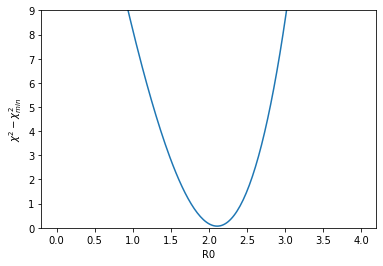

In [25]:
today=len(xdata)

def minimizer(R0,t1=today-5,t2=today):
    
    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))
    
    #model
    fin_result=time_evo(60*10**6,1/14*R0,1/14,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]
    
    #average error
    error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100
    chi2=np.sum((ydata_inf_2-i_vec_2)**2/ydata_inf_2)/(len(ydata_inf_2)-1)
    
    return chi2

minimizer_vec=np.vectorize(minimizer)


#definition of the ideal r0

xgrid=np.linspace(0,4,200)
ygrid=minimizer_vec(xgrid)
r0_ideal=round(xgrid[np.argmin(ygrid)],2)
print(r0_ideal)

plt.plot(xgrid,ygrid)
plt.ylabel('$\\chi^2-\\chi^2_{min}$')
plt.ylim(0,9)
plt.xlabel('R0')
plt.show()

In [24]:
r0range=xgrid[(ygrid>=0.95) & (ygrid<=1.05)]

print(r0range)

[1.66834171 2.49246231]


### model for the italian situation

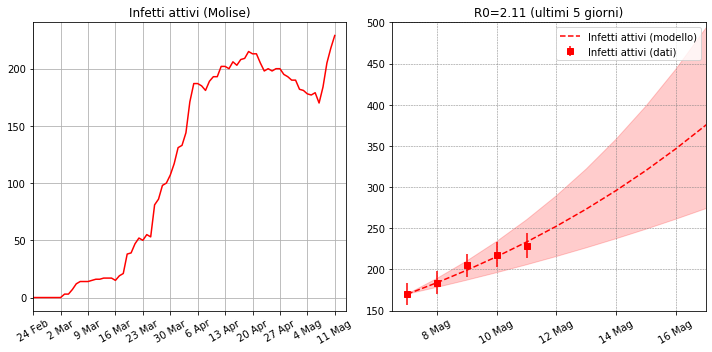

In [29]:
ydata_inf_2=np.array(ydata_inf[today-5:today])
xdata_2=np.arange(0,len(ydata_inf_2))

fin_result=time_evo(3*10**5,1/14*r0_ideal,1/14,I0=ydata_inf_2[0])

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]

upper_lim=time_evo(3*10**5,1/14*r0range[1],1/14,I0=ydata_inf_2[0])[2]
lower_lim=time_evo(3*10**5,1/14*r0range[0],1/14,I0=ydata_inf_2[0])[2]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ydata_inf,color='red')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.title('Infetti attivi (Molise)')
plt.xlim(0,80)
plt.grid()
plt.subplot(1,2,2)
plt.errorbar(xdata_2,ydata_inf_2,np.sqrt(ydata_inf_2),color='red',linestyle='None',marker='s',label='Infetti attivi (dati)')
plt.plot(t, i_vec, 'r--', label='Infetti attivi (modello)')
plt.fill_between(t, upper_lim,lower_lim,alpha=0.2,color='red')
#plt.yscale('log')
#plt.xticks(np.arange(14,70,7),['21 Feb','28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr'],rotation=30)
plt.xticks(np.arange(1,17,2),['8 Mag','10 Mag','12 Mag','14 Mag','16 Mag','18 Mag','20 Mag','22 Mag','24 Mag','26 Mag'],rotation=30)
plt.xlim(-0.5,10)
plt.ylim(ydata_inf_2.max()*0.8,ydata_inf_2.max()*1.2)
plt.ylim(150,500)
#plt.xlabel('Data')
#plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('R0='+str(r0_ideal)+' (ultimi 5 giorni)')
plt.tight_layout()
plt.savefig('output/r0-5days.png',dpi=300)
plt.show()

In [29]:
 # 213 19 Aprile
    # 170 minimo
    # 218 ieri
    # +65 nuovi positivi

### scan di R0 nel corso del tempo

In [10]:
time_window=5

def minimizer_gen(t1,t2):

    xgrid=np.arange(0.1,5,0.01)
    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]

for i in range(today-(time_window-1)):
    min_val=minimizer_gen(i,i+time_window)
    r0_time.append(min_val)
    print(i,min_val)
    
r0_time=np.array(r0_time)

/Users/andreapalladino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/andreapalladino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


0 0.1
1 0.1
2 0.1
3 0.1
4 0.1
5 0.1
6 0.1
7 0.1
8 4.99
9 4.99
10 3.93
11 1.84
12 1.35
13 1.5
14 1.7
15 1.5
16 1.25
17 1.04
18 1.01
19 1.42
20 2.84
21 4.49
22 4.33
23 4.5
24 2.15
25 2.32
26 1.54
27 1.86
28 2.8
29 3.05
30 3.58
31 2.02
32 2.08
33 1.89
34 2.08
35 2.08
36 2.18
37 2.14
38 2.37
39 2.12
40 1.33
41 0.96
42 1.04
43 1.15
44 1.37
45 1.25
46 1.17
47 1.23
48 1.03
49 1.08
50 1.16
51 1.1
52 1.21
53 1.11
54 1.02
55 0.77
56 0.74
57 0.69
58 0.87
59 1.04
60 0.95
61 0.94
62 0.83
63 0.79
64 0.81
65 0.78
66 0.77
67 0.71
68 0.91
69 0.84
70 1.0
71 1.29


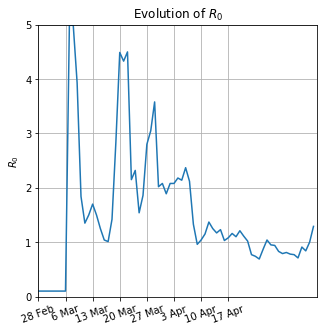

In [11]:
plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid()
plt.title('Evolution of $R_0$')
plt.savefig('output/r0-evo.png',dpi=300)
plt.show()

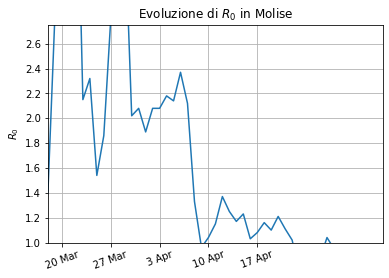

In [12]:
#plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
#plt.xlim(0,today-4)
plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(1,2.75)
plt.grid()
plt.title('Evoluzione di $R_0$ in Molise')
plt.savefig('output/r0-evo-molise.png',dpi=300)
plt.show()

In [13]:
df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time)),unit='D',origin='2020-02-28'))
df_r0['R0']=r0_time
df_r0.columns=['Data','R0']

In [14]:
df_r0.to_csv('output/r0.csv',index=False)

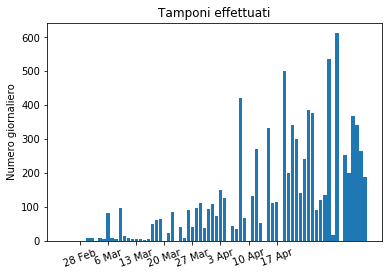

In [15]:
data_tamponi=np.array(data['tamponi'])
incr_tamponi=[data_tamponi[0]]

for i in range(len(data_tamponi)-1):
    incr_tamponi.append(data_tamponi[i+1]-data_tamponi[i])

plt.bar(np.arange(len(incr_tamponi)),incr_tamponi)
plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.ylabel('Numero giornaliero')
plt.title('Tamponi effettuati')
plt.show()

In [16]:
print('media tamponi ',np.mean(incr_tamponi))

print('deviazione standard tamponi ',np.std(incr_tamponi))

media tamponi  114.35526315789474
deviazione standard tamponi  144.30894343910117


### caso regionale (Molise)

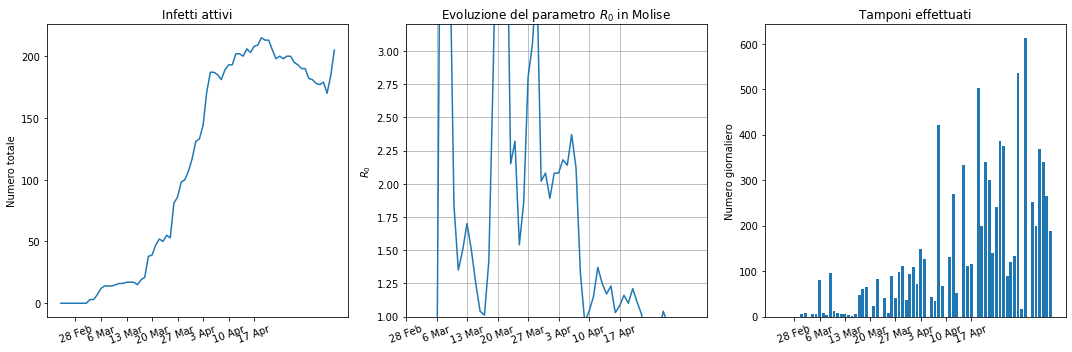

In [17]:
if scelta=='regionale':
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(ydata_inf)
    plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.ylabel('Numero totale')
    plt.title('Infetti attivi')
    plt.subplot(1,3,2)
    plt.plot(r0_time)
    plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.xlim(0,today-7)
    plt.ylabel('$R_0$')
    plt.ylim(1,3.2)
    plt.grid()
    plt.title('Evoluzione del parametro $R_0$ in Molise')
    plt.subplot(1,3,3)
    plt.bar(np.arange(len(incr_tamponi)),incr_tamponi)
    plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.ylabel('Numero giornaliero')
    plt.title('Tamponi effettuati')
    plt.tight_layout()
    plt.savefig('output/r0-evo-Molise.png',dpi=300)
    plt.show()
else:
    print('Regional plot not available. Please change the choice of the parameter scelta in scelta=regionale')

## loop regionale su R0 (time window, 7 giorni)

In [18]:
datatot = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

def R0_regioni(nome):

    mask = datatot['denominazione_regione']==nome
    data =datatot.loc[mask,:]
    xdata=pd.to_numeric(range(data.shape[0]))
    ydata=data['totale_casi']
    ydata_death=data['deceduti']
    ydata_rec=data['dimessi_guariti']
    ydata_inf=np.array(ydata-ydata_death-ydata_rec)

    today=len(xdata)

    def minimizer(R0,t1=today-7,t2=today):
    
        #true data
        ydata_inf_2=np.array(ydata_inf[t1:t2])
        xdata_2=np.arange(0,len(ydata_inf_2))
    
        #model
        fin_result=time_evo(60*10**6,1/14*R0,1/14,I0=ydata_inf_2[0])
        i_vec=fin_result[2]
        i_vec_2=i_vec[0:len(xdata_2)]
    
        #average error
        error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100
    
        return error

    minimizer_vec=np.vectorize(minimizer)


    #definition of the ideal r0

    xgrid=np.arange(0.01,1.3,0.01)
    ygrid=minimizer_vec(xgrid)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)
    r0_ideal

    return r0_ideal

In [19]:
R0_regioni('Molise')

0.95

In [20]:
name_regions       = np.array(['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna','Friuli Venezia Giulia','Lazio','Liguria','Lombardia','Marche','Molise','Piemonte','Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto'])
R0_list=[]

for name in name_regions:
    R0_list.append(R0_regioni(name))
    print(name)

R0_list=np.array(R0_list)

Abruzzo
Basilicata
P.A. Bolzano
Calabria
Campania
Emilia-Romagna
Friuli Venezia Giulia
Lazio
Liguria
Lombardia
Marche
Molise
Piemonte
Puglia
Sardegna
Sicilia
Toscana
P.A. Trento
Umbria
Valle d'Aosta
Veneto


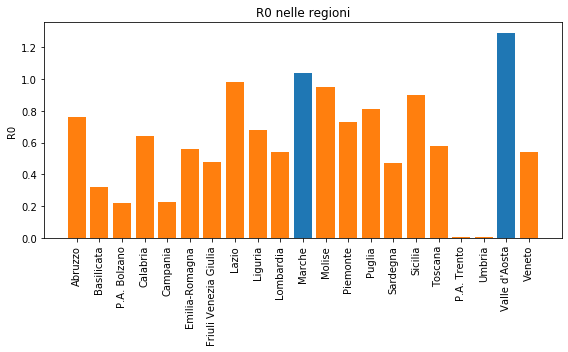

In [21]:
maskR0= R0_list < 1

xgriglia=np.arange(len(R0_list))

plt.figure(figsize=(8,5))
plt.bar(xgriglia,R0_list)
plt.bar(xgriglia[maskR0],R0_list[maskR0])
plt.xticks(np.arange(len(R0_list)),name_regions,rotation=90)
plt.tight_layout()
plt.title('R0 nelle regioni')
plt.ylabel('R0')
plt.tight_layout()
plt.savefig('output/r0-histogram.png',dpi=300)
plt.show()

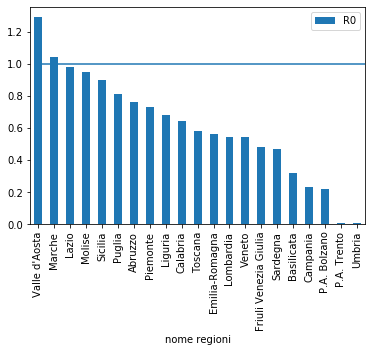

In [22]:
df_r0_regioni=pd.DataFrame(list(zip(name_regions,R0_list)))
df_r0_regioni.columns=['nome regioni','R0']
df_r0_regioni.index=df_r0_regioni['nome regioni']
df_r0_regioni.drop('nome regioni',axis=1,inplace=True)
df_r0_regioni=df_r0_regioni.sort_values(by='R0',ascending=False)


df_r0_regioni.plot(kind='bar')
plt.plot(np.arange(0,22),np.arange(0,22)*0+1)
plt.show()